# 在 Diffusion model -> ESM loss vs. DSM loss


## ESM 與 DSM 理論與目標函數對照

### **1. ESM（Hyvärinen Score Matching）**

直接在原始資料分佈 $p_{\text{data}}(x)$ 上學習 score 函數  
$s_\theta(x) \approx \nabla_x \log p(x)$。

目標函數為：
$$
\mathcal{L}_{\text{ESM}}
= \mathbb{E}_{x}\Big[\tfrac{1}{2}\|s_\theta(x)\|^2 + \operatorname{div}_x s_\theta(x)\Big],
$$

其中散度項可利用 **Hutchinson’s trick** 近似：
$$
\operatorname{tr}(J) \approx v^\top (\partial s / \partial x) v,
$$
$ v $ 為隨機向量（常用 Rademacher 或 Gaussian 噪聲）。

---

#### **2. DSM（Denoising Score Matching）**

在加噪後的平滑分佈  
$$
q_\sigma = p * \mathcal{N}(0, \sigma^2 I)
$$
上學習 denoised score：
$$
s_\theta(y, \sigma) \approx \nabla_y \log q_\sigma(y),
$$
其中 $ y = x + \sigma z, \; z \sim \mathcal{N}(0, I) $。

目標函數為：
$$
\mathcal{L}_{\text{DSM}}
= \mathbb{E}\Big[\lambda(\sigma)
   \big\|s_\theta(y, \sigma) - \tfrac{x - y}{\sigma^2}\big\|^2\Big].
$$

常見選擇是 $\lambda(\sigma) = \sigma^2$ 來平衡不同噪聲層級。

---

### **3. 理論上**

- DSM 學的是「**平滑後的 score**」$ \nabla_y \log q_\sigma(y) $。  
- 當 $ \sigma \to 0 $ 時，$ q_\sigma \to p $，此時 DSM 與 ESM 等價（相差常數項）。

因此：
- 在固定 $ \sigma > 0$ 時，兩種 loss 不會完全一致。  
- 若令 $ \sigma $ 很小，DSM 模型在 **ESM 評估** 下會趨近於 ESM 模型。  
- 同樣地，ESM 模型在小 $\sigma$ 的 **DSM 目標** 下，其 loss 也會與 DSM 模型接近。

---

## DATASET
- 簡單 $2D$ 高斯混合（兩團雲）。

- **模型**：同一結構的 MLP  
  - **ESM 版**：輸入 $x$。  
  - **DSM 版**：輸入 $[x, \log\sigma]$。
  - 
- **訓練**：各自用自己的 loss 訓練。

- **評估（關鍵）**：
  1. 各自的 **native loss**（ESM→ESM，DSM→DSM）。
  2. **交叉評估**：
     - 把 **DSM 模型**拿去算 **ESM loss**（在非常小的 $\sigma \approx 10^{-3}$ 帶入）。
     - 把 **ESM 模型**拿去算 **DSM loss**（用訓練時的 $\sigma$，如 $0.2$）。
  3. 畫訓練曲線，列出四個指標數值。


## Main code

In [2]:
import math, random, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F

torch.manual_seed(0); np.random.seed(0); random.seed(0)
device = "cpu"

In [15]:
def sample_gmm(n=2048):
    n1 = n // 2
    n2 = n - n1
    mean1 = torch.tensor([0.0, 0.0], dtype=torch.float32)
    mean2 = torch.tensor([3.0, 3.0], dtype=torch.float32)
    cov1  = torch.tensor([[1.0, 0.3],[0.3, 1.2]], dtype=torch.float32)
    cov2  = torch.tensor([[0.6,-0.2],[-0.2, 0.8]], dtype=torch.float32)
    L1, L2 = torch.linalg.cholesky(cov1), torch.linalg.cholesky(cov2)
    z1 = torch.randn(n1, 2) @ L1.T + mean1
    z2 = torch.randn(n2, 2) @ L2.T + mean2
    x  = torch.cat([z1, z2], dim=0)
    return x[torch.randperm(n1+n2)].to(device)


In [25]:
class ScoreMLP(nn.Module):
    def __init__(self, in_dim=2, hidden=64, use_sigma=False):
        super().__init__()
        self.use_sigma = use_sigma
        eff_in = in_dim + (1 if use_sigma else 0)  # append log_sigma if DSM
        self.fc1 = nn.Linear(eff_in, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, in_dim)
        for m in [self.fc1, self.fc2, self.fc3]:
            nn.init.xavier_uniform_(m.weight); nn.init.zeros_(m.bias)
    def forward(self, x, sigma=None):
        if self.use_sigma and (sigma is not None):
            if not torch.is_tensor(sigma):
                sigma = torch.tensor(float(sigma), dtype=x.dtype, device=x.device)
            h = torch.cat([x, torch.log(sigma).expand(x.shape[0],1)], dim=1)
        else:
            h = x
        h = F.silu(self.fc1(h))
        h = F.silu(self.fc2(h))
        return self.fc3(h)

def esm_loss(model, x, num_trace_samples=6):

    x = x.detach().requires_grad_(True)
    s = model(x, sigma=None)                      # (N,d)
    sq = 0.5 * (s * s).sum(dim=1)                 # (N,)
    div_est = 0.0
    for _ in range(num_trace_samples):
        v  = torch.empty_like(x).bernoulli_(0.5).mul_(2).sub_(1)  # Rademacher ±1
        sv = (s * v).sum()
        (grad_x,) = torch.autograd.grad(sv, x, create_graph=True, retain_graph=True)
        div_est = div_est + (grad_x * v).sum(dim=1)               # v^T J v
    div_est = div_est / float(num_trace_samples)
    return (sq + div_est).mean()

def dsm_loss(model, x, sigma, lambda_by_sigma=True):
    
    sigma  = torch.tensor(float(sigma), device=x.device)
    y      = x + sigma * torch.randn_like(x)
    target = (x - y) / (sigma * sigma)
    pred   = model(y.detach(), sigma=sigma)
    per    = (pred - target)
    per    = (per * per).sum(dim=1)               # manual MSE over dims
    if lambda_by_sigma:
        per = (sigma * sigma) * per
    return per.mean()

In [26]:
# =======  ESM Loss  ==========
def train_esm(model, steps, batch, lr, num_trace_samples):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=steps)
    history = []
    for t in range(1, steps + 1):
        x = sample_gmm(batch)
        loss = esm_loss(model, x, num_trace_samples=num_trace_samples)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        scheduler.step() 

        history.append(loss.item())
        print(f"[Step {t:04d}] ESM loss = {loss.item():.6f} | lr={scheduler.get_last_lr()[0]:.6g}")
    return history


# =======  DSM Loss  ==========
def train_dsm(model, sigma, steps, batch, lr):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=steps)
    history = []
    for t in range(1, steps + 1):
        x = sample_gmm(batch)
        loss = dsm_loss(model, x, sigma=sigma, lambda_by_sigma=True)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        scheduler.step()  

        history.append(loss.item())
        print(f"[Step {t:04d}] DSM loss = {loss.item():.6f} | lr={scheduler.get_last_lr()[0]:.6g}")
    return history


In [27]:
m_esm = ScoreMLP(use_sigma=False).to(device)
m_dsm = ScoreMLP(use_sigma=True ).to(device)

ESM_STEPS, DSM_STEPS = 500,500         
BATCH = 1024       
esm_curve = train_esm(m_esm, steps=ESM_STEPS, batch=BATCH, lr=5e-4, num_trace_samples=6)
dsm_curve = train_dsm(m_dsm, steps=DSM_STEPS, batch=BATCH, lr=5e-4, sigma=0.3)

### ==== Evaluation
with torch.no_grad():
    X_eval = sample_gmm(5000)

native_esm = esm_loss(m_esm, X_eval).item()
native_dsm = dsm_loss(m_dsm, X_eval, sigma=0.2, lambda_by_sigma=True).item()

# DSM-model under ESM (use tiny sigma so its learned map approximates s(x))
class WrapDSM(nn.Module):
    def __init__(self, base, tiny_sigma=1e-3):
        super().__init__(); self.base=base; self.tiny_sigma=tiny_sigma
    def forward(self, x, sigma=None): return self.base(x, sigma=self.tiny_sigma)

# ESM-model under DSM (ignore sigma in forward)
class WrapESM(nn.Module):
    def __init__(self, base): super().__init__(); self.base=base
    def forward(self, x, sigma=None): return self.base(x, sigma=None)

cross_esm_on_dsm = esm_loss(WrapDSM(m_dsm, tiny_sigma=1e-3), X_eval).item()
cross_dsm_on_esm = dsm_loss(WrapESM(m_esm), X_eval, sigma=0.2, lambda_by_sigma=True).item()


[Step 0001] ESM loss = 0.421847 | lr=0.000499995
[Step 0002] ESM loss = 0.374276 | lr=0.00049998
[Step 0003] ESM loss = 0.338068 | lr=0.000499956
[Step 0004] ESM loss = 0.296088 | lr=0.000499921
[Step 0005] ESM loss = 0.260800 | lr=0.000499877
[Step 0006] ESM loss = 0.225997 | lr=0.000499822
[Step 0007] ESM loss = 0.191482 | lr=0.000499758
[Step 0008] ESM loss = 0.165233 | lr=0.000499684
[Step 0009] ESM loss = 0.137887 | lr=0.0004996
[Step 0010] ESM loss = 0.110460 | lr=0.000499507
[Step 0011] ESM loss = 0.084940 | lr=0.000499403
[Step 0012] ESM loss = 0.065252 | lr=0.00049929
[Step 0013] ESM loss = 0.043008 | lr=0.000499166
[Step 0014] ESM loss = 0.030149 | lr=0.000499033
[Step 0015] ESM loss = 0.008470 | lr=0.00049889
[Step 0016] ESM loss = -0.007218 | lr=0.000498738
[Step 0017] ESM loss = -0.020920 | lr=0.000498575
[Step 0018] ESM loss = -0.033539 | lr=0.000498403
[Step 0019] ESM loss = -0.044052 | lr=0.000498221
[Step 0020] ESM loss = -0.056310 | lr=0.000498029
[Step 0021] ESM loss

In [28]:
print("=== TRAIN DONE ===")
print(f"Native ESM (ESM-trained):            {native_esm:.6f}")
print(f"Native DSM (DSM-trained, sigma=0.2): {native_dsm:.6f}")
print(f"ESM of DSM-model (sigma≈0):          {cross_esm_on_dsm:.6f}")
print(f"DSM of ESM-model (sigma=0.2):        {cross_dsm_on_esm:.6f}")


=== TRAIN DONE ===
Native ESM (ESM-trained):            -0.766199
Native DSM (DSM-trained, sigma=0.2): 1.930658
ESM of DSM-model (sigma≈0):          0.479277
DSM of ESM-model (sigma=0.2):        1.957994


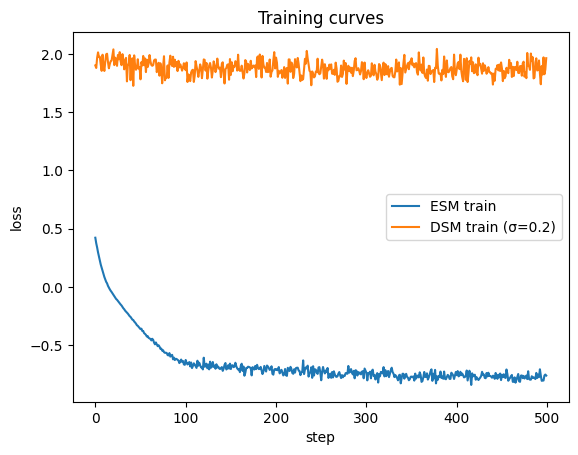

In [29]:
import matplotlib.pyplot as plt

plt.figure(); 
plt.plot(esm_curve, label="ESM train")
plt.plot(dsm_curve, label="DSM train (σ=0.2)")
plt.xlabel("step")
plt.ylabel("loss")
plt.legend()
plt.title("Training curves")
plt.show()
